# Recommendation Steam Games

Progetto di Programmazione di applicazioni Data Intensive 2024/2025
Federico Mantoni, Giuseppe Marini

Il progetto ha lo scopo di creare un sistema di recommendation di giochi per PC presenti sulla piattaforma Steam.

## Inizializzazione librerie

 È stato creato un piccolo script per installare tutte le librerie necessarie al progetto

In [1]:
#Impostare a False una volta installate le librerie

if True:
    import sys
    import subprocess
    import platform

    def run_cmd(cmd):
        try:
            subprocess.check_call(cmd, shell=True)
        except Exception as e:
            print(f"Command failed: {cmd}\n{e}")

    def is_windows():
        return platform.system() == "Windows"

    def install(package):
        if is_windows():
            try:
                run_cmd(f"conda install -y {package.split()[0]}")
                return
            except Exception:
                print(f"Conda installation failed for {package}, trying pip...")
        try:
            run_cmd(f"{sys.executable} -m pip install --upgrade pip")
            run_cmd(f"{sys.executable} -m pip install {package}")
        except Exception as e:
            print(f"Pip installation failed for {package}: {e}")
            run_cmd(f"!pip install {package}")

    packages = [
        "numpy",
        "numpy<2.0,>=1.20",
        "pandas",
        "scikit-learn",
        "matplotlib",
        "jovian --upgrade --quiet",
        "kaggle",
        "numpy.typing",
        "scikit-surprise"
        "lightfm"
    ]

    if os.path.exists(r"C:\Users\manto\\"):
        run_cmd(f"{sys.executable} -m pip uninstall numpy -y")
        for pkg in packages:
            install(pkg)



In [2]:
# CARICAMENTO DELLE LIBRERIE

import numpy as np
import pandas as pd
import random
import csv
import os
import matplotlib.pyplot as plt
import jovian
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
import surprise
from datetime import datetime
from surprise import Reader, Dataset, model_selection, SVD, SVDpp, NMF, KNNBasic, KNNWithMeans, accuracy, NormalPredictor
from surprise.accuracy import rmse, mae
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score
from lightfm.cross_validation import random_train_test_split


<IPython.core.display.Javascript object>

## Caricamento dataset principale recommendation

Il dataset principale comprende 4 file

- games.csv = dati sui giochi

- recommendations.csv = il dataset delle recensioni, quello che ci serve per la recommendation

- users.csv = dati su utenti, non è stato considerato per questo progetto

- games_metadata.json = dati aggiunti vi sui giochi in formato json

In [ ]:
# DOWNLOAD DEL DATASET PRINCIPALE
# Scarichiamo il dataset principale da Kaggle sfruttando la libreria omonima e lo estraiamo.
if True:
    !mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    ! kaggle datasets download antonkozyriev/game-recommendations-on-steam 
    ! unzip game-recommendations-on-steam.zip -d games_dataset """


Per velocizzare i tempi di esecuzione, e' stata creata una versione più piccola del dataset delle raccomandazioni (~50%).
Per semplicità l'esecuzione di questo processo e' avvenuta facendo sì che ogni riga letta abbia un 50% di essere scartata

In [2]:
# Seed impostato per replicazione dei risultati
random.seed(42)
if not os.path.exists('recommendations_half.csv'):
    with open('games_dataset/recommendations.csv', 'r') as inp, open('recommendations_half.csv', 'w') as out:
        writer = csv.writer(out)
        for i, row in enumerate(csv.reader(inp)):
            if random.random() < 0.5 or i == 0:
                writer.writerow(row)



Dato che il nostro dataset presentava dati di tipo binario, abbiamo trasformato randomicamente ma con criterio, i valori in voti positivi e negativi in un range da 1 a 5.
Inoltre abbiamo droppato i valori date, funny e review_id, non utili per il nostro caso.

In [4]:
rec_data = pd.read_csv("recommendations_half.csv", index_col=0)
random.seed(42)
def rank_stats(value):
   if str(value).lower() == 'true':
      return np.random.choice([4, 5], p=[0.3, 0.7])
   else:
      return np.random.choice([1, 2], p=[0.7, 0.3])
rec_data.drop(columns=['date','funny','review_id'], inplace=True)
rec_data['is_recommended'] = rec_data['is_recommended'].map(rank_stats)
rec_data=rec_data.rename(columns={'is_recommended': 'rank'})

rec_data ha come dati principali

- app_id: id univoco del gioco dato da Steam

- user_id: id univoco dell'user

- is_recommended: se l'user_id ha apprezzato o meno il gioco

In [5]:
rec_data

,helpful,rank,hours,user_id
app_id,,,,
975370,0,4,36.3,51580
304390,4,1,11.5,2586
1085660,2,4,336.5,253880
238960,0,4,538.8,88282
730,0,1,157.5,63209
...,...,...,...,...
391220,0,5,12.0,12406164
633230,0,4,41.0,1606890
696170,3,1,2.0,6370324


## Caricamento e pulizia dati aggiuntivi

Il secondo dataset con dati aggiuntivi su alcuni giochi Steam, è stato scaricato da openML
Dal secondo set a nostra disposizione abbiamo inizialmente estratti le colonne StreamURL, Metacritic, Platform, Tags, Languages.
In un secondo momento, osservando che alcuni dati erano già presenti in altri dataset(Tags, Platform) o avevano molti valore a NaN (metacritic), è stata mantenuta solo la colonna "Languages", che contiene le lingue in cui è disponibile in ogni gioco

Per permettere un join con le altre tabelle, è stato trasformato il dato "SteamURL"

In [10]:

df = fetch_openml(data_id=43689)
secdata = pd.DataFrame({
    "SteamURL": df.data["SteamURL"],
    "Metacritic": df.data["Metacritic"],
    "Platform": df.data["Platform"],
    "Tags": df.data["Tags"],
    "Languages": df.data["Languages"]
})
secdata = secdata.dropna(axis='rows', subset=["SteamURL", "Tags"])
secdata['SteamURL'] = secdata['SteamURL'].str[35:-16]
secdata.drop_duplicates(subset=['SteamURL'], inplace=True)
secdata['SteamURL'] = secdata['SteamURL'].astype('int64')
secdata.index = secdata['SteamURL']
secdata.drop(columns='SteamURL', inplace=True)
print(secdata.describe())
secdata.head()

        Metacritic
count  3311.000000
mean     72.928722
std      10.807617
min      20.000000
25%      67.000000
50%      74.000000
75%      80.000000
max      97.000000


,Metacritic,Platform,Tags,Languages
SteamURL,,,,
730,83.0,"PC, Xbox 360, PlayStation 3","FPS, Shooter, Multiplayer, Competitive, Action...","English, Czech, Danish, Dutch, Finnish, French..."
1085660,82.0,"PlayStation 5, Web, Xbox Series X, PC, Xbox On...","Free to Play, Looter Shooter, FPS, Multiplayer...","English, French, Italian, German, Japanese, Ko..."
570,90.0,"Linux, macOS, PC","Free to Play, MOBA, Multiplayer, Strategy, eSp...","English, Bulgarian, Czech, Danish, Dutch, Finn..."
306130,71.0,PC,"RPG, MMORPG, Open World, Massively Multiplayer...","English, French, German, Russian"
1172620,68.0,"PC, Xbox One","Adventure, Action, Pirates, Open World, Multip...","English, French, Italian, German, Russian"


Abbiamo poi elaborato la colonna delle lingue poiché' erano tutte array sotto forma di un unica stringa. abbiamo convertito le stringhe in array di stringhe e le abbiamo poi esplose in singole colonne binarie

In [11]:
# ENCODING ONE-HOT DELLE LINGUE

secdata['Languages'] = secdata['Languages'].dropna().str.replace(r"[ \[\]']", '', regex=True).str.split(',')
mlb = MultiLabelBinarizer()
multi_hot = mlb.fit_transform(secdata["Languages"])
secdata.drop(columns=['Tags', 'Platform', 'Metacritic'], inplace=True)
secdata = secdata.join(pd.DataFrame(multi_hot, columns=mlb.classes_, index=secdata.index))
secdata.drop(columns=['Languages'], inplace=True)
secdata.head()


,Arabic,Bulgarian,Czech,Danish,Dutch,English,Finnish,French,German,Greek,...,Polish,Portuguese,Romanian,Russian,Slovakian,Swedish,Thai,Turkish,Ukrainian,Vietnamese
SteamURL,,,,,,,,,,,,,,,,,,,,,
730,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
1085660,0,0,0,0,0,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,0
570,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,0
306130,0,0,0,0,0,1,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
1172620,0,0,0,0,0,1,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0


## Caricamento e pulizia metadata

Nel dataset principale era incluso anche con un file json con alcuni dati aggiuntivi: descrizione del gioco e tags.
Abbiamo eliminato la colonna della descrizione, fare un modello "bag of words" non è il nostro obiettivo.

In [40]:
# CARICAMENTO E PULIZIA DEI TAG (da metadata.json)
# Leggiamo i tag dai metadati dei giochi, li puliamo e trasformiamo in one-hot.

metadata = pd.read_json("games_dataset/games_metadata.json", lines="True")
metadata.to_csv("data3.csv", encoding='utf-8', index=False)
tagsdata = pd.read_csv("data3.csv", index_col=0)
tagsdata = tagsdata.drop(columns='description')
tagsdata.drop(tagsdata[tagsdata['tags'].str.len() == 2].index, inplace=True)  # rimuovi tag vuoti
tagsdata['tags'] = tagsdata['tags'].dropna().str.replace(r"[ \[\]']", '', regex=True).str.split(',')
tagsdata = tagsdata.loc[tagsdata.index.isin(secdata.index)]  # filtra per app_id in secdata
multi_hot = mlb.fit_transform(tagsdata['tags'])
tagsdata = tagsdata.join(pd.DataFrame(multi_hot, columns=mlb.classes_, index=tagsdata.index))
tagsdata.drop(columns='tags', inplace=True)
print("Numero di tag distinti =", tagsdata.columns.size)

Numero di tag distinti = 441


Il terzo dataset lo estraiamo da un file csv. Il dataset risultate e' esente da particolari criticità, quindi procediamo a eliminare colonne contenenti dati non utili al nostro scopo. Abbiamo convertito le colonne dei sistemi operativi per preparali all'addestramento.

In [22]:
# CARICAMENTO DEL DATASET PRINCIPALE DEI GIOCHI (games.csv)
# Prepariamo il dataset principale: pulizia, encoding, normalizzazione.

bigdata = pd.read_csv("./games_dataset/games.csv", index_col=0)
bigdata.drop(columns=['title', 'user_reviews', 'discount', 'price_original', "steam_deck", "rating"], inplace=True)
bigdata['win'] = bigdata['win'].astype(float)
bigdata['mac'] = bigdata['mac'].astype(float)
bigdata['linux'] = bigdata['linux'].astype(float)
bigdata.head()


,date_release,win,mac,linux,positive_ratio,price_final
app_id,,,,,,
13500,2008-11-21,1.0,0.0,0.0,84,9.99
22364,2011-08-03,1.0,0.0,0.0,85,2.99
113020,2013-04-24,1.0,1.0,1.0,92,14.99
226560,2014-11-18,1.0,0.0,0.0,61,14.99
249050,2014-10-27,1.0,1.0,0.0,88,11.99


Qui vengono estratti i singoli campi di una data (mese e anno) e successivamente le abbiamo convertite in stringhe e normalizzato le recensioni in un range da 0 a 1

In [23]:
bigdata['date_release'] = pd.to_datetime(bigdata['date_release'])
bigdata["year"] = bigdata["date_release"].dt.year
bigdata["month"] = bigdata["date_release"].dt.month
bigdata.drop(columns="date_release", inplace=True)

scaler = MinMaxScaler()
num_features = scaler.fit_transform(bigdata[['year', 'month', 'price_final', 'positive_ratio']])
bigdata_std = bigdata.join(pd.DataFrame(num_features, columns=['year_std', 'month_std', 'price_final_std', 'positive_ratio_std'], index=bigdata.index))
bigdata_std.drop(columns=['year', 'month', 'price_final', 'positive_ratio'], inplace=True)
bigdata.head()


,win,mac,linux,positive_ratio,price_final,year,month
app_id,,,,,,,
13500,1.0,0.0,0.0,84,9.99,2008,11
22364,1.0,0.0,0.0,85,2.99,2011,8
113020,1.0,1.0,1.0,92,14.99,2013,4
226560,1.0,0.0,0.0,61,14.99,2014,11
249050,1.0,1.0,0.0,88,11.99,2014,10


## Analisi dei dati

Abbiamo analizzato i dati in diversi grafici

- Distribuzione degli utenti per numero di recensioni eseguite

- Distribuzione dei giochi per numero di recensioni

- piattaforme - istogramma

- grafico a torta che descrive varie fasce di prezzo dei giochi

- istogramma - positive ratio 

- analisi mese - istogramma

- Correlazione ps ratio e prezzo

- Correlazione num recensioni vs mese

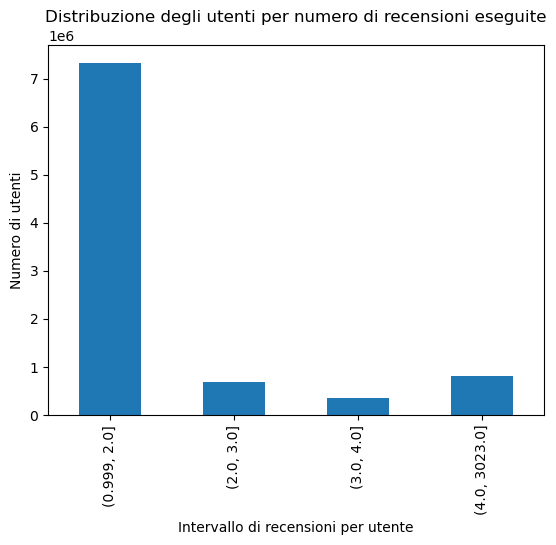

In [24]:
user_rew_bar=pd.qcut(rec_data.groupby('user_id').size(), 10, duplicates='drop').value_counts().sort_index().plot.bar()
plt.xlabel("Intervallo di recensioni per utente")
plt.ylabel("Numero di utenti")
user_rew_bar.set_title("Distribuzione degli utenti per numero di recensioni eseguite")
plt.show()


Ci accorgiamo che molti dgli utenti hanno lasciato meno di 2 recensioni. Questo ci avverte che se avessimo una matrice utenti x giochi, questa matrice sarebbe molto sparsa, quindi l'ai avrà difficolta ad imparare da essa. 

In [30]:
print("Sparsità matrice = ", rec_data.shape[0]/(rec_data.index.nunique()*rec_data['user_id'].nunique())*100,"%")

Sparsità matrice =  0.006034255696724082 %


Analizziamo in maggior dettaglio gli utenti con un grande numero di recensioni

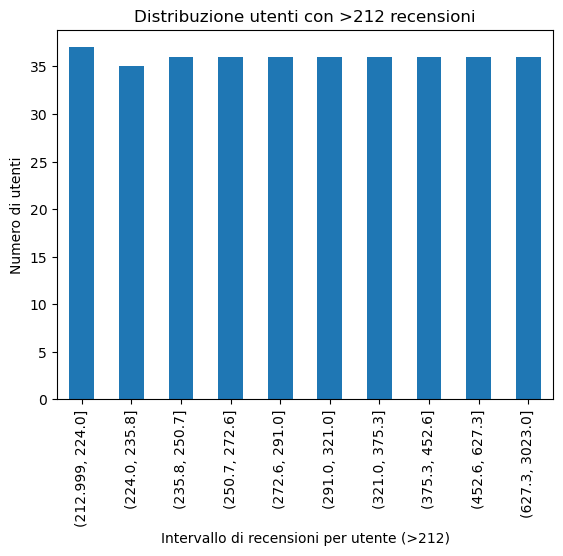

In [ ]:
(rec_data['user_id'].value_counts()>1000).sum()
# Filtra solo gli utenti con più di 200 recensioni
filtered_users = rec_data['user_id'].value_counts()
active_users = filtered_users[filtered_users > 200].index
filtered_rec_data = rec_data[rec_data['user_id'].isin(active_users)]
# Conta le recensioni per utente tra quelli filtrati
review_counts = filtered_rec_data['user_id'].value_counts()
# Crea l'istogramma con pd.qcut
review_bins = pd.qcut(review_counts, 10, duplicates='drop')
review_bins.value_counts().sort_index().plot.bar()
plt.xlabel("Intervallo di recensioni per utente (>200)")
plt.ylabel("Numero di utenti")
plt.title("Distribuzione utenti con >200 recensioni")
plt.show()


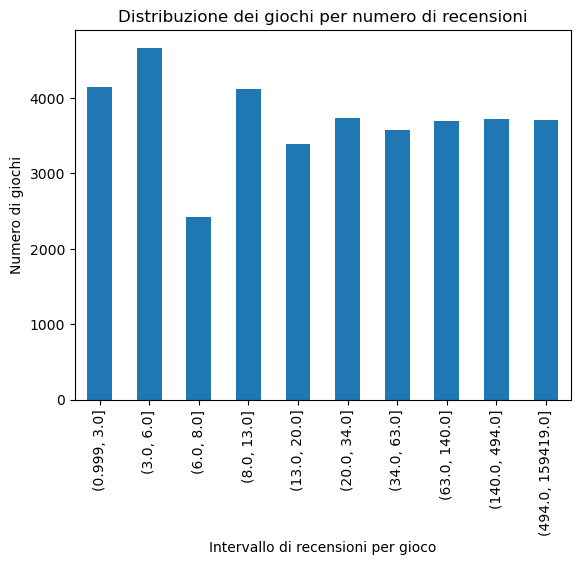

In [31]:
game_rew_bar=pd.qcut(rec_data.index.value_counts(), 10, duplicates='drop').value_counts().sort_index().plot.bar()
plt.xlabel("Intervallo di recensioni per gioco")
plt.ylabel("Numero di giochi")
game_rew_bar.set_title("Distribuzione dei giochi per numero di recensioni")
plt.show()


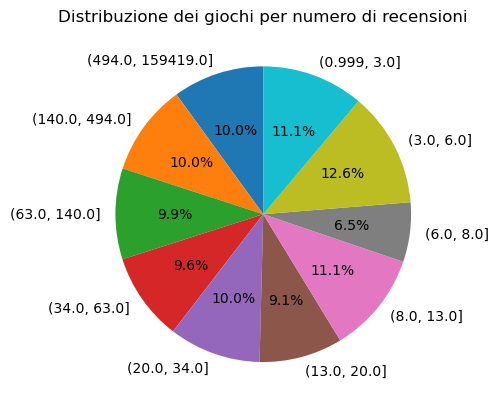

In [36]:
games_pie=pd.qcut(rec_data.index.value_counts(), 10, duplicates='drop').value_counts().sort_index(ascending=False).plot.pie(autopct='%1.1f%%', startangle=90)
games_pie.set_title("Distribuzione dei giochi per numero di recensioni")
games_pie.set_ylabel("")
plt.show()


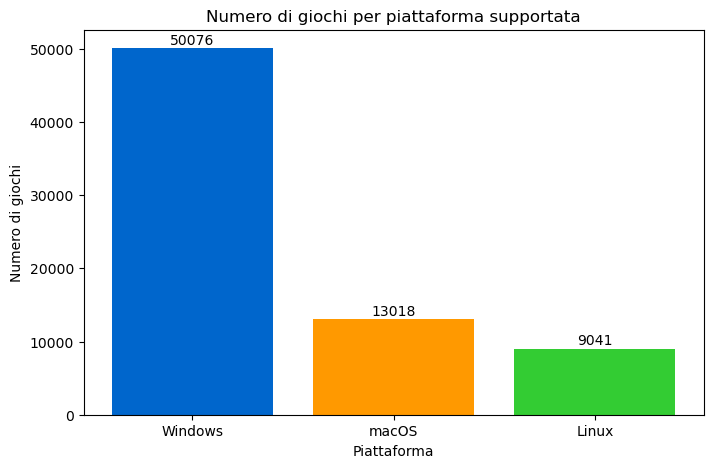

In [43]:
#Distribuzione delle piattaforme supportate

platform_counts = {
    'Windows': bigdata['win'].sum(),
    'macOS': bigdata['mac'].sum(),
    'Linux': bigdata['linux'].sum()
}

plt.figure(figsize=(8, 5))
plt.bar(platform_counts.keys(), platform_counts.values(), color=['#0066cc', '#ff9900', '#33cc33'])
plt.title("Numero di giochi per piattaforma supportata")
plt.ylabel("Numero di giochi")
plt.xlabel("Piattaforma")
for i, v in enumerate(platform_counts.values()):
    plt.text(i, v + 100, str(int(v)), ha='center', va='bottom')
plt.show()


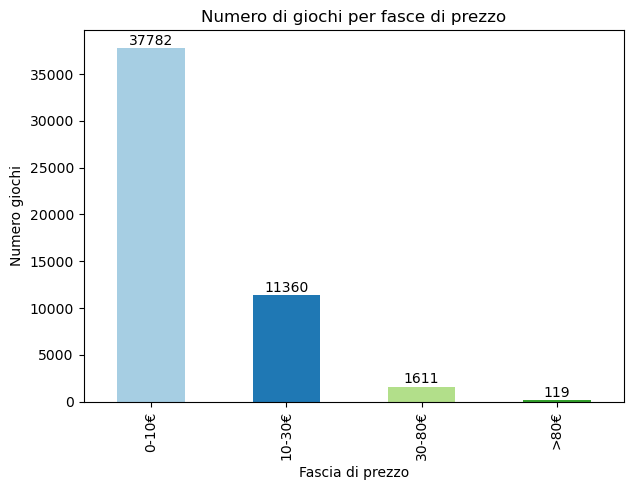

In [44]:
#Prezzo dei giochi - Fasce in euro

bigdata_price = bigdata.copy()
bins = [0, 10, 30, 80, float('inf')]
labels = ['0-10€', '10-30€', '30-80€', '>80€']
bigdata_price['price_bin'] = pd.cut(bigdata_price['price_final'], bins=bins, labels=labels, right=False)

price_counts = bigdata_price['price_bin'].value_counts().sort_index()

plt.figure(figsize=(12, 5))

# Istogramma
plt.subplot(1, 2, 2)
price_counts.plot.bar(color=plt.cm.Paired(range(len(price_counts))))
plt.title("Numero di giochi per fasce di prezzo")
plt.ylabel("Numero giochi")
plt.xlabel("Fascia di prezzo")
for i, v in enumerate(price_counts):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()


Si osserva che la maggior parte dei giochi sono in un range di costo tra 0 e 10€, mentre i giochi con costo >30€ sono solo un numero molto ridotto

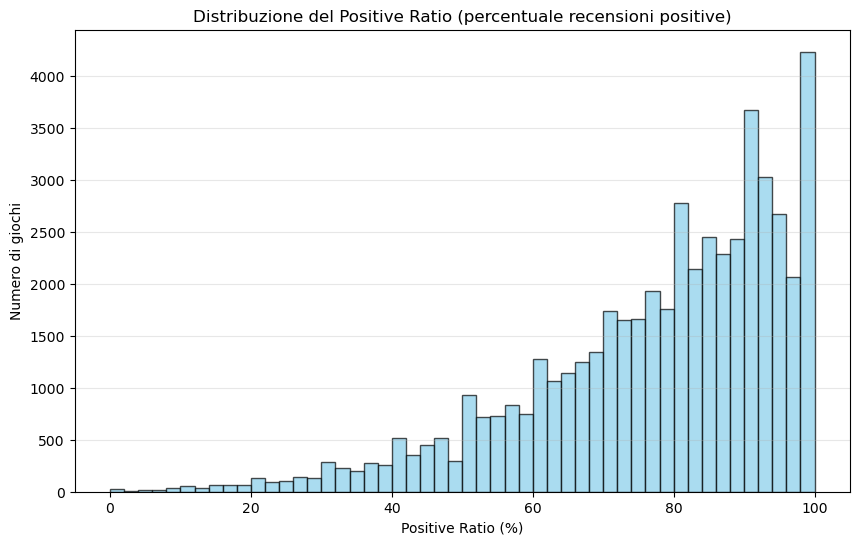

In [45]:
# Distribuzione del positive_ratio

bigdata_ratio = bigdata.copy()

plt.figure(figsize=(10, 6))
plt.hist(bigdata_ratio['positive_ratio'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribuzione del Positive Ratio (percentuale recensioni positive)")
plt.xlabel("Positive Ratio (%)")
plt.ylabel("Numero di giochi")
plt.grid(axis='y', alpha=0.3)
plt.show()


Notiamo che la gran parte dei giochi è valutata positivamente, quindi che gli utenti tendono a lasciare un numero di recensioni positive maggiore rispetto a quelle negative, osservazione riflettuta anche dal dataset di recensioni.

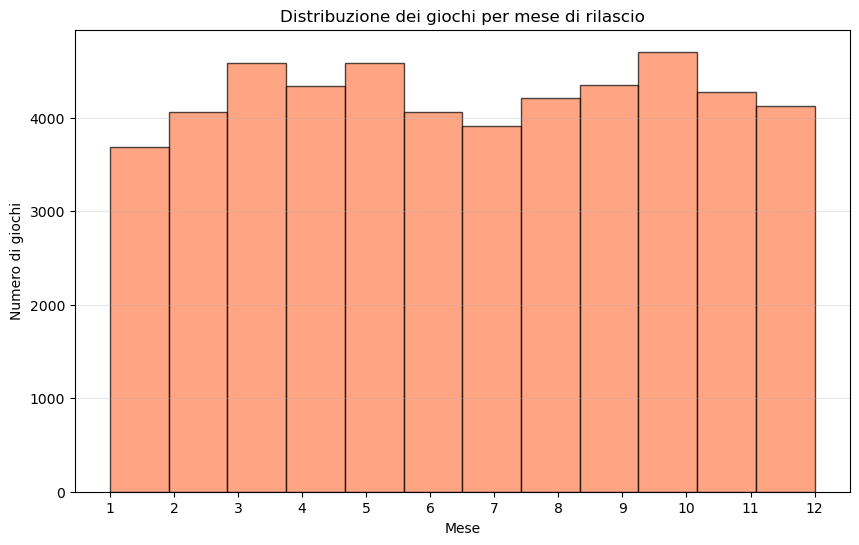

In [46]:
# Numero di giochi rilasciati per mese

if 'month' not in bigdata.columns:
    bigdata_temp = pd.read_csv("./games_dataset/games.csv", index_col=0)
    bigdata_temp['date_release'] = pd.to_datetime(bigdata_temp['date_release'])
    months = bigdata_temp['date_release'].dt.month
else:
    months = bigdata['month']

plt.figure(figsize=(10, 6))
months.plot.hist(bins=12, color='coral', alpha=0.7, edgecolor='black')
plt.title("Distribuzione dei giochi per mese di rilascio")
plt.xlabel("Mese")
plt.ylabel("Numero di giochi")
plt.xticks(range(1, 13))
plt.grid(axis='y', alpha=0.3)
plt.show()


Notiamo che il numero di giochi usciti nei diversi mesi dell'anno non varia di molto.

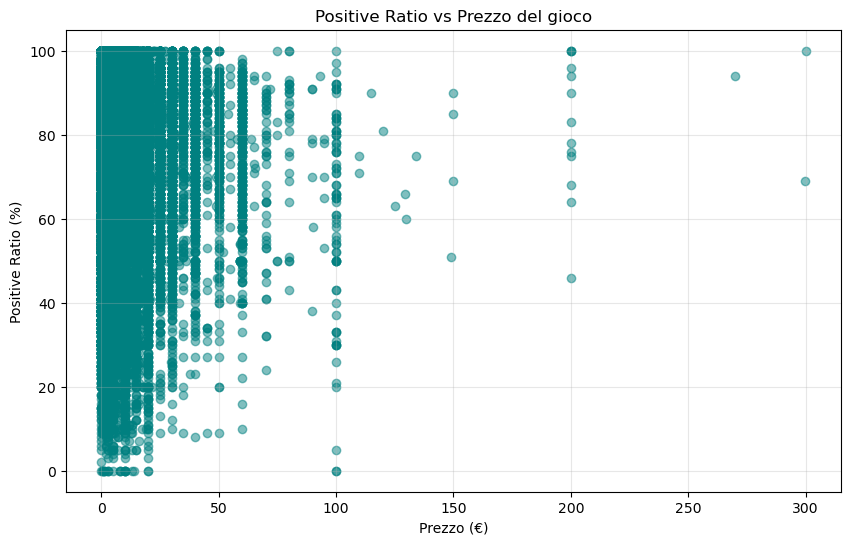

Correlazione tra prezzo e positive ratio: -0.010


In [47]:
#Positive Ratio vs Prezzo
# si controlla se c'è correlazione tra prezzo e valutazione del prodotto

bigdata_plot = bigdata.copy()

plt.figure(figsize=(10, 6))
plt.scatter(bigdata_plot['price_final'], bigdata_plot['positive_ratio'], alpha=0.5, color='teal')
plt.title("Positive Ratio vs Prezzo del gioco")
plt.xlabel("Prezzo (€)")
plt.ylabel("Positive Ratio (%)")
plt.grid(True, alpha=0.3)
plt.show()


# Correlazione
corr = bigdata_plot['price_final'].corr(bigdata_plot['positive_ratio'])
print(f"Correlazione tra prezzo e positive ratio: {corr:.3f}")

Notiamo che i giochi con costo <100€ hanno un indice di gradimento che sembra essere random, mentre notiamo una concentrazione di recensioni positive per giochi molto costosi, anche se il numero di dati a riguardo è ridotto
Dato che la maggior parte dei dati sono di giochi che costano meno di 100€, possiamo dire che non c'è una correlazione tra prezzo e positive ratio, come mostrato anche dal valore di correlazione calcolato

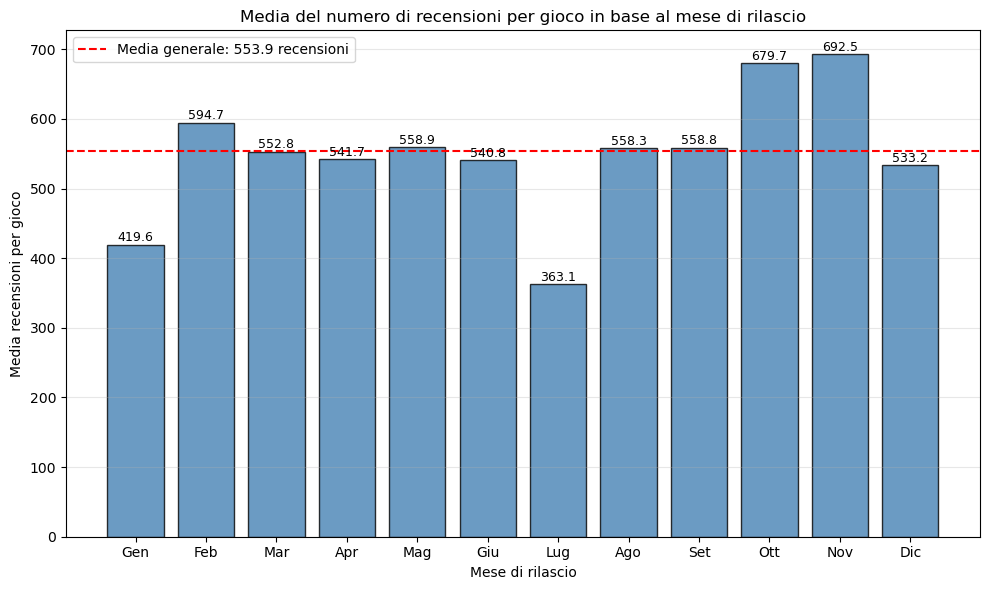

Media recensioni per mese di rilascio:
month
1     419.6
2     594.7
3     552.8
4     541.7
5     558.9
6     540.8
7     363.1
8     558.3
9     558.8
10    679.7
11    692.5
12    533.2
Name: review_count, dtype: float64


In [48]:
# %%
# GRAFICO: Numero di recensioni per gioco in base al mese di rilascio
# Analizza se i giochi usciti in certi mesi ricevono più attenzione (recensioni)

# Viene recuperato il mese di rilascio per ogni gioco
# Assicuriamoci che 'month' sia disponibile
if 'month' not in bigdata.columns:
    temp_games = pd.read_csv("./games_dataset/games.csv", index_col=0)
    temp_games['date_release'] = pd.to_datetime(temp_games['date_release'])
    game_months = temp_games['date_release'].dt.month
    game_months.index = temp_games.index  # app_id
else:
    game_months = bigdata['month'].copy()

# Viene contato quante recensioni ha ogni gioco (app_id)
reviews_per_game = rec_data.index.value_counts()

merged = pd.DataFrame({
    'month': game_months,
    'review_count': reviews_per_game
}).dropna()  # solo giochi con recensioni e mese noto

# Calcola la media delle recensioni per mese
reviews_by_month = merged.groupby('month')['review_count'].mean()

# Istogramma
plt.figure(figsize=(10, 6))
bars = plt.bar(reviews_by_month.index, reviews_by_month.values, color='steelblue', alpha=0.8, edgecolor='black')

# Media generale
overall_avg = reviews_per_game.mean()
plt.axhline(overall_avg, color='red', linestyle='--', label=f'Media generale: {overall_avg:.1f} recensioni')

plt.title("Media del numero di recensioni per gioco in base al mese di rilascio")
plt.xlabel("Mese di rilascio")
plt.ylabel("Media recensioni per gioco")
plt.xticks(range(1, 13), ['Gen', 'Feb', 'Mar', 'Apr', 'Mag', 'Giu', 'Lug', 'Ago', 'Set', 'Ott', 'Nov', 'Dic'])

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Stampa valori
print("Media recensioni per mese di rilascio:")
print(reviews_by_month.round(1))

Notiamo che in alcuni mesi soprattuto invernali ed estivi (Gennaio e Luglio), il numero di recensioni cala di molto.
Ottobre e novembre sembrano i mesi con più recensioni, che può avere senso dato che un importante evento di videogiochi chiamato "Game Awards" si tiene proprio a inizio dicembre

## Recommendation - Surprise

Per iniziare si prova a sviluppare un modello di recommendation semplice, che non tiene conto delle feature.
Surprise accetta dataframe con 3 colonne ordinate in questo modo: utenti, prodotti, voti, quindi.
Si andrà a passare a surprise le giuste colonne nell'ordine voluto

In [6]:
# PREPARAZIONE DATI PER SURPRISE

rec_data=rec_data.loc[rec_data['user_id'].isin((rec_data['user_id'].value_counts()).iloc[:3000].index)]
datasurprise = rec_data.drop(columns=["helpful", "hours"])
datasurprise = datasurprise.reset_index()

print(datasurprise)

df_reader = Reader(rating_scale=(1, 5))
datasurprise = surprise.Dataset.load_from_df(datasurprise[['user_id', 'app_id', 'rank']], df_reader)

         app_id  rank   user_id
0       1325200     5  11593837
1       1240440     1  11247431
2        394360     5  10159024
3       1286830     5   5847936
4        397540     5   7620549
...         ...   ...       ...
444061     6910     1  11783959
444062   203160     5   6528047
444063  1818450     5  13261742
444064   362960     5   7858713
444065   633230     1   8107668

[444066 rows x 3 columns]


Si provano i diversi modelli che Surprise mette a disposizione

In [ ]:
algo = NormalPredictor()
result=model_selection.cross_validate(algo, datasurprise, verbose=True)

print(result['test_rmse'].max())

Dopo alcune prove non presenti in questo momento, si è visto che la similarità migliore 

In [ ]:
# CROSS-VALIDATION
algo = KNNBasic(k=300)
result=model_selection.cross_validate(algo, datasurprise, verbose=True)

print(result['test_rmse'].max())

In [ ]:

algo = KNNWithMeans(k=300)
model_selection.cross_validate(algo, datasurprise, verbose=True)

print(result['test_rmse'].max())


In [ ]:
# Train-test split e valutazione modelli
trainset, testset = surprise.model_selection.train_test_split(datasurprise, test_size=0.3)

model = SVD()
model.fit(trainset)
preds = model.test(testset)
print("SVD RMSE, MAE:", rmse(preds), mae(preds))



In [ ]:
model_svdpp = SVDpp()
model_svdpp.fit(trainset)
preds_svdpp = model_svdpp.test(testset)
print("SVDpp RMSE:", accuracy.rmse(preds_svdpp))



Come si denota, i risultati non sono soddisfacenti, al contrario la poca coerenza delle raccomandazioni porta a definirle casuali, conseguenza dell'assenza di dati aggiuntivi da cui il modello possa imparare come consigliare correttamente dei videogiochi. L'assenza del grid search deriva da test effettuati manualmente che verificano l'assenza di miglioramento dei risultati anche con iperparametri di diversi valori 

## Recommendation con features con LightFM

LightFM è una libreria che lavora principalmente con dati impliciti (feature come n° click, n°like) e molto sparsi
I Dataset presi in oggetto sono molto sparsi quindi l'uso di questa libreria risulta ideale. 
Il vantaggio di lightFM è che permette di usare le features per addestrare meglio il modello e aumentare la precisione del modello

lightFM lavora con dati con range (0,1]. Dati uguali a 0 vengono ignorati
I dati delle feature caricati all'inizio sono stati normalizzati appositamente in questa maniera.

 La matrice contenente l'insieme delle feature trattate in precedenza viene creata collegando coerentemente i dati tramite join 

In [ ]:
# MATRICE FEATURES PER LIGHTFM
features_matrix = (bigdata_std.join(secdata, on="app_id", how="inner")).join(tagsdata, on="app_id", how="inner")



Estraiamo nuovamente il file recommendations_half.csv lasciando solo i 3 parametri app_id, user_id e is_recommended
Si decide di prendere solo i valori binari positivi, successivamente trasformati in 1, che per il modello che addestriamo equivale ad una interazione positiva.
Una possibilità era tenere i dati a 0 come "interazione negativa", ma non è il modo migliore di sfruttare questo tipo di modello visto si basa sulla presenza o assenza di interazione, quindi non abbiamo bisogno di questo tipo di interazioni

Altro accorgimento che verra' preso, sia per ridurre la mole di dati sia per far sì che le feature possano essere sfruttate al massimo, vengono prese solo le recensioni di giochi di cui abbiamo dati aggiuntivi.

In [ ]:
# Preparazione dati LightFM: solo recensioni positive
light_data = pd.read_csv("recommendations_half.csv", index_col=0)
light_data.drop(columns=['date', 'funny', 'review_id', 'helpful', 'hours'], inplace=True)
light_data.reset_index(inplace=True)
light_data = light_data.loc[light_data['is_recommended'] == True]
light_data = light_data.loc[light_data['app_id'].isin(features_matrix.index)]



Il dataset rimanente risulta comunque molto grande, di conseguenza ne verra' ridotta la dimensione.
Inizialmente, il team di progetto ha pensato di prendere un gruppo di utenti ponderato in base al numero di recensioni lasciate.
Il modello è stato addestrato con questo dataset, ma i risultati sono stati molto insoddisfacenti, poiché la maggior parte degli utenti, come si può vedere in uno dei grafici, ha un numero di recensioni minore di 2

In [ ]:
# Campionamento utenti per fasce di attività
N = 12500
user_counts = light_data.groupby("user_id").size().reset_index(name="n_reviews")
bins = [0, 2, 5, 20, float("inf")]
labels = ["1-2", "3-5", "6-20", "20+"]
user_counts["fascia"] = pd.cut(user_counts["n_reviews"], bins=bins, labels=labels)

min_per_fascia = {"1-2": 3000, "3-5": 3000, "6-20": 3000, "20+": 500}
selected_users = []
for fascia, group in user_counts.groupby("fascia"):
    n_min = min_per_fascia.get(fascia, 0)
    n_take = min(len(group), n_min)
    sampled = group.sample(n=n_take, random_state=42)
    selected_users.append(sampled)
selected_users = pd.concat(selected_users)

remaining_slots = N - len(selected_users)
if remaining_slots > 0:
    remaining_pool = user_counts[~user_counts["user_id"].isin(selected_users["user_id"])]
    extra = remaining_pool.groupby("fascia").apply(
        lambda g: g.sample(n=min(len(g), int(remaining_slots * len(g) / len(remaining_pool))), random_state=42)
    ).reset_index(drop=True)
    selected_users = pd.concat([selected_users, extra])

light_data_red = light_data[light_data["user_id"].isin(selected_users["user_id"])]
# Ci assicuriamo che nella features_matrix siano presenti solo le feature dei videogiochi rimasti
features_matrix = features_matrix.loc[features_matrix.index.isin(light_data_red['app_id'].unique())]
print(light_data_red.shape[0]/(light_data_red['app_id'].nunique()*light_data_red['user_id'].nunique()))



Per diminuire la sparsità della matrice si prendono i primi 7000 utenti con più recensioni lasciate. Anche così la matrice rimane sparsa,  ma risulta più accettabile

In [ ]:
lightdata_m = light_data.loc[light_data['user_id'].isin(light_data['user_id'].value_counts().iloc[:7000].index)]
# Ci assicuriamo che nella features_matrix siano presenti solo le feature dei videogiochi rimasti
features_matrix = features_matrix.loc[features_matrix.index.isin(lightdata_m['app_id'].unique())]
print(lightdata_m.shape[0]/(lightdata_m['app_id'].nunique()*lightdata_m['user_id'].nunique()))

Vengono eseguite le ultime modifiche al dataset. LightFM richiede che i nomi delle colonne, per quanto riguarda prodotti e utenti, siano di tipo stringa, mentre il valore deve essere di tipo float.

Altro accorgimento: gli indici (quindi gli item) della feature matrix devono essere ordinati allo stesso modo dell'array di item che passeremo alla funzione di LightFM.

Infine, ci si accorge che alcuni valori della feature matrix sono pari a 0 a causa della normalizzazione [0,1], e non perché esprimono il concetto di falso. Il modello ignorerebbe i dati uguali a 0; per far sì che abbiano rilevanza, aggiungiamo un epsilon =1e−6 a tutti i dati. Il valore è abbastanza basso da non influire sull'accuratezza dei dati.

In [ ]:
# Preparazione finale dati LightFM
lightdata = lightdata_m.copy()
lightdata['is_recommended'] = lightdata['is_recommended'].astype(int)
lightdata = lightdata.rename(columns={"app_id": "item_id", "is_recommended": "weight"})
lightdata = lightdata[['user_id', 'item_id', 'weight']]

lightdata['user_id'] = lightdata['user_id'].astype(str)
lightdata['item_id'] = lightdata['item_id'].astype(str)
lightdata['weight'] = lightdata['weight'].astype(float)

users = lightdata['user_id'].unique()
items = lightdata['item_id'].unique()

item_to_index = {item: idx for idx, item in enumerate(features_matrix.index.astype(str))}
items_sorted = sorted(items, key=lambda x: item_to_index[x])

features_matrix[['year_std', 'price_final_std']] += 1e-6
features_matrix.index = features_matrix.index.astype(str)



Vengono passati a LightFM i dati nel modo richiesto, e viene splittato il dataset in train_set e test_set

In [ ]:
# CREAZIONE DATASET LIGHTFM
dataset = Dataset()
dataset.fit(users, items, item_features=features_matrix.columns.tolist())

interactions, weights = dataset.build_interactions(lightdata.itertuples(index=False, name=None))
item_features = dataset.build_item_features(
    (item, features_matrix.columns[features_matrix.loc[item] > 0])
    for item in features_matrix.index
)
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)



LightFM non dispone di una gridSearch integrata, quindi abbiamo scritto un codice a mano per simulare il suo comportamento.
Non è stata eseguita la gridSearch per K fold, dato che il processo avrebbe impiegato troppo tempo.


Il valore che dovremo tenere di conto è il valore K-precision, che indica quanto sono rilevanti i primi k-videogiochi consigliati dall'AI

In [ ]:
# TUNING IPERPARAMETRI LIGHTFM
param_grid = {
    "no_components": [10, 20, 50],
    "learning_rate": [0.01, 0.05, 0.1],
    "epochs": [20, 30, 50],
    "item_alpha": [1e-5, 1e-4, 1e-3]
}
results = []

for n in param_grid["no_components"]:
    for lr in param_grid["learning_rate"]:
        for ep in param_grid["epochs"]:
            for l2 in param_grid["item_alpha"]:
                model = LightFM(no_components=n, learning_rate=lr, loss="warp", random_state=42)
                model.fit(train, epochs=ep, num_threads=8, verbose=False, item_features=item_features)
                precision = precision_at_k(model, test, k=10, item_features=item_features, num_threads=8).mean()
                auc = auc_score(model, test, item_features=item_features, num_threads=8).mean()
                results.append({
                    "no_components": n, "lr": lr, "epochs": ep,
                    "precision": precision, "auc": auc, "item_alpha": l2
                })
                print(f"n={n}, lr={lr}, ep={ep}, l2={l2} -> prec@10={precision:.4f}, auc={auc:.4f}")

results_sorted = sorted(results, key=lambda x: x["precision"], reverse=True)
results_sorted_auc = sorted(results, key=lambda x: x["auc"], reverse=True)
print("Best precision:\n", results_sorted[0])
print("Best AUC:\n", results_sorted_auc[0])



Dopo aver effettuato la grid search, si analizzano gli iper parametri con cui ottenere il miglior risultato
In particolare si vede che usando adagrad come loss function, il risultato tende a migliorare con l'aumentare delle epoche (adagrad ha un effetto opposto)
Quindi si esegue il fit con un numero maggiore di componentes e di epoche (entrambi a 100) ed il risultato è migliorato

In [ ]:
# ADDESTRAMENTO MODELLO LIGHTFM FINALE
model = LightFM(no_components=100, loss="warp", item_alpha=1e-4, learning_rate=0.1)
model.fit(train, epochs=100, item_features=item_features, num_threads=4)



Ci si accorge che la differenza non è significativa rispetto all'aumento di epoche e dimensioni del modello, quindi concludiamo che il modello sia arrivato a convergere

In [ ]:
# VALUTAZIONE MODELLO
prec = precision_at_k(model, test, item_features=item_features, k=10, num_threads=4).mean()
auc = auc_score(model, test, item_features=item_features, num_threads=4).mean()
print(f"Precision@10: {prec:.4f} | AUC: {auc:.4f}")



Il risultato finale con k10 precision= 0.0389 confrontato con quello di altri modelli (come amazon reviews) risulta essere ottimo.

In [ ]:
# FUNZIONE DI RACCOMANDAZIONE TOP-K
def recommend_topk(model, dataset, interactions_csr, user_id, k=5):
    user_id_map, _, item_id_map, _ = dataset.mapping()
    u_internal = user_id_map[str(user_id)]
    item_labels = {v: k for k, v in item_id_map.items()}
    scores = model.predict(u_internal, np.arange(interactions_csr.shape[1]))
    seen = interactions_csr.tocsr()[u_internal].indices
    scores[seen] = -np.inf
    top_items = np.argsort(-scores)[:k]
    return [item_labels[i] for i in top_items]



In [ ]:
# ESEMPIO DI RACCOMANDAZIONE PER 3 UTENTI CASUALI
for u in np.random.choice(users, 3, replace=False):
    raccomandazioni = recommend_topk(model, dataset, train, u, k=5)
    print(f"User {u} -> Recommended games: {raccomandazioni}")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=65e2a800-7967-42b4-96c9-bf5538064c40' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>